In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
# import hvplot.pandas
# import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os

In [2]:

url = f"https://min-api.cryptocompare.com/data/all/coinlist"
crypto_df= pd.read_csv("crypto_data.csv", index_col=[0])
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [3]:
crypto_df.dtypes

CoinName            object
Algorithm           object
IsTrading             bool
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [4]:
# Keep only cryptocurrencies that are on trading
crypto_df= crypto_df[crypto_df["IsTrading"]== True]

In [5]:
# Keep only cryptocurrencies with a working algorithm
crypto_df= crypto_df[crypto_df['Algorithm']!= 'N/A']

In [6]:
# Remove the "IsTrading" column
crypto_df.drop(columns=['IsTrading'], inplace=True)
crypto_df.head(10)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,PoW,6.303924e+07,84000000


In [7]:
# Find null values
for column in crypto_df.columns:
    print(f"Column {column} has {crypto_df[column].isnull().sum()} null values")

Column CoinName has 0 null values
Column Algorithm has 0 null values
Column ProofType has 0 null values
Column TotalCoinsMined has 459 null values
Column TotalCoinSupply has 0 null values


In [8]:
# Removing rows with at least 1 null value
crypto_df= crypto_df.dropna()

In [9]:
# Removing rows with cryptocurrencies without coins mined
crypto_df= crypto_df[crypto_df["TotalCoinsMined"]> 0]


In [10]:
# Removing rows where there are 'N/A' text values
crypto_df= crypto_df[crypto_df!='N/A']

In [11]:
# Removing the cryptocurrency name since it's not going to be used on the clustering algorithm
crypto_df.drop(columns=['CoinName'], inplace=True)

In [12]:
crypto_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [13]:

crypto_df.dtypes

Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [14]:
# Creating dummies variables for text features
crypto_binary= pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'])
crypto_binary.head(10)

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LTC,6.303924e+07,84000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DASH,9.031294e+06,22000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
XMR,1.720114e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETC,1.133597e+08,210000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZEC,7.383056e+06,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Standardizing data by scaling 
crypto_scaled= StandardScaler().fit_transform(crypto_binary)
crypto_scaled

array([[-0.11710817, -0.1528703 , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.09396955, -0.145009  , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [ 0.52494561,  4.48942416, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       ...,
       [-0.09561336, -0.13217937, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11694817, -0.15255998, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11710536, -0.15285552, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ]])

Dimensionality Reduction

In [16]:
# Initialize PCA model
pca = PCA(n_components=3)

# Get three principal components for the data.
crypto_pca = pca.fit_transform(crypto_scaled)
crypto_pca

array([[-0.32844148,  0.96329727, -0.58634821],
       [-0.31180351,  0.96332911, -0.58672524],
       [ 2.31055617,  1.54436442, -0.67658009],
       ...,
       [ 0.31890339, -2.32370922,  0.39718433],
       [-0.10107869, -2.00908531,  0.45739052],
       [-0.28449236,  0.80287063, -0.29702226]])

In [17]:
# Transform PCA data to a DataFrame
df_crypto_pca = pd.DataFrame(
    data=crypto_pca, columns=["pc1", "pc2", "pc3"], index= crypto_df.index
)
df_crypto_pca.head()

,pc1,pc2,pc3
42,-0.328441,0.963297,-0.586348
404,-0.311804,0.963329,-0.586725
1337,2.310556,1.544364,-0.676580
BTC,-0.150903,-1.285086,0.185199
ETH,-0.157973,-1.955336,0.394649


In [18]:
# Fetch the explained variance
pca.explained_variance_ratio_

array([0.02792947, 0.02137892, 0.02050592])

Analysis: 
According to the explained variance, the first principal component contains approximately 3% of the variance, the second principal component contains 2% of the variance and the third principal component contains 2% of the variance. With three principal components, we have 7% of the information in the original dataset.

Cluster Analysis with k-Means

In [19]:
# Identify the best number of clusters using the elbow curve
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_crypto_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

C:\Users\clseg\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,k,inertia
0,1,3639.838662
1,2,2476.504751
2,3,1483.620518
3,4,521.584056
4,5,329.453347


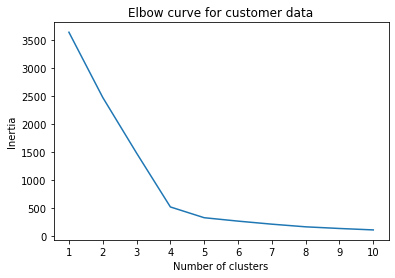

In [20]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [23]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Train the model
model.fit(df_crypto_pca)

# Predict clusters
predictions = model.predict(df_crypto_pca)


# Create new df and return DataFrame with predicted clusters
df_crypto_cluster = pd.concat([crypto_df, df_crypto_pca], axis=1, sort=False)
# df_crypto_cluster["CoinName"] = coins_name["CoinName"]
df_crypto_cluster["Class"] = model.labels_
print(df_crypto_cluster.shape)

(532, 8)


In [24]:
df_crypto_cluster.head(10)    

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,pc1,pc2,pc3,Class
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.328441,0.963297,-0.586348,3
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.311804,0.963329,-0.586725,3
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.310556,1.544364,-0.676580,3
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.150903,-1.285086,0.185199,0
ETH,Ethash,PoW,1.076842e+08,0,-0.157973,-1.955336,0.394649,0
LTC,Scrypt,PoW,6.303924e+07,84000000,-0.162451,-1.144135,-0.028960,0
DASH,X11,PoW/PoS,9.031294e+06,22000000,-0.404328,1.269631,-0.480889,3
XMR,CryptoNight-V7,PoW,1.720114e+07,0,-0.158049,-2.158873,0.417013,0
ETC,Ethash,PoW,1.133597e+08,210000000,-0.156418,-1.955453,0.394625,0
ZEC,Equihash,PoW,7.383056e+06,21000000,-0.101078,-2.009085,0.457390,0


In [27]:
# Analyzing Clusters with the Best Value of k
# clusters = get_clusters(3, crypto_df)

print(predictions)

[3 3 3 0 0 0 3 0 0 0 3 0 3 3 0 3 0 0 3 3 0 0 0 0 0 3 0 0 0 3 0 3 0 0 3 3 0
 0 0 0 0 0 3 3 0 0 0 0 0 3 3 0 3 0 0 0 0 3 0 0 3 0 3 3 3 0 0 0 3 3 3 3 3 0
 0 0 3 3 0 3 0 3 3 0 0 0 0 3 3 0 3 0 0 3 3 0 3 3 0 0 3 3 0 3 3 0 3 0 3 0 3
 0 3 3 0 0 3 0 0 0 3 0 0 0 0 0 3 3 0 0 0 3 0 3 0 0 3 0 3 0 3 3 0 0 3 0 0 3
 3 0 3 0 3 3 3 0 0 0 0 3 3 3 3 3 0 0 3 3 3 3 3 0 3 3 3 3 3 0 3 0 3 3 0 3 0
 3 3 0 3 0 3 0 3 0 3 3 3 3 0 3 3 3 3 3 0 0 3 3 0 0 3 3 3 3 3 0 3 3 3 3 3 3
 3 3 0 3 3 3 3 3 3 0 0 0 3 3 3 3 0 3 0 3 3 0 3 0 0 3 0 0 3 0 3 3 3 0 3 3 0
 3 3 3 3 3 3 3 0 3 0 3 3 3 3 0 3 0 3 0 0 0 0 3 0 3 3 0 3 0 0 0 3 0 3 0 0 0
 3 0 3 0 3 3 3 0 3 0 0 0 0 0 3 3 0 3 3 3 0 3 0 3 0 3 0 3 3 3 3 0 3 3 0 3 3
 3 0 0 0 0 3 3 3 3 0 3 0 0 0 3 3 0 0 3 3 0 3 0 0 0 3 0 0 3 3 3 0 0 0 3 3 3
 0 0 3 0 0 0 0 3 1 1 0 0 0 3 1 3 3 3 3 0 0 0 0 3 3 3 0 3 0 3 3 3 3 0 3 3 0
 3 3 0 0 3 0 3 0 0 0 0 3 3 0 3 0 3 3 3 3 3 3 0 0 0 3 3 3 3 3 3 0 3 0 0 0 0
 3 3 3 3 0 3 3 0 3 3 0 1 0 3 0 0 3 3 0 3 0 0 3 0 0 3 0 3 0 3 3 0 3 3 3 3 3
 0 0 0 3 3 3 0 3 0 3 0 3 

Recommendation: Can the cryptocurrencies be clustered together? If so, into how many clusters?

Based on my findings cryptocurrencies can be clustered together into 4 categories based on the elbow chart.
